In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
# Paramaters
test_frac=.20           #split for train and test dataset
seed_random=42          #seed to for experiment repetition
learning_rate=0.0001     #alghtorim learning rate
epochs = 200            #epochs
step_epoch=10           #report epoch
synth_frac=0.3          #% of the synthetic data usage

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt




In [ ]:
df=pd.read_csv("TravelInsurancePrediction.csv")

In [ ]:
def Subplots(df, title):
  

    # Columns to plot
    columns_to_plot = ['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome', 
    'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad']

    # Number of rows and columns in the subplot grid
    n_rows = 3
    n_cols = 3

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

    # Flatten the array of axes for easy indexing
    axs = axs.flatten()

    # Plot each column
    for i, col in enumerate(columns_to_plot):
        data_count = df.groupby([col, 'TravelInsurance']).size().unstack()
        percentage_data = data_count.div(data_count.sum(axis=1), axis=0) * 100

        # Plotting
        percentage_data.plot(kind='bar', stacked=True, ax=axs[i])


        # Setting titles and labels
        axs[i].set_title(col)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Counts')

    # Adjust layout
    plt.tight_layout()

    plt.subplots_adjust(top=0.90)
    fig.suptitle(title, fontsize=20)

    # Show plot
    plt.show()

def plot_pdf(df, title):
    columns_to_plot = ['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome', 
                    'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad']

    # Number of rows and columns in the subplot grid
    n_rows = 3
    n_cols = 3

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

    # Set the main title
    fig.suptitle('Probability Distributions', fontsize=16)

    # Flatten the array of axes for easy indexing
    axs = axs.flatten()

    # Plot each column
    for i, col in enumerate(columns_to_plot):
        # Choose the plot type based on the data type
        if df[col].dtype == 'O':  # Categorical data
            sns.countplot(x=col, data=df, ax=axs[i])
        else:  # Numerical data
            sns.histplot(df[col], kde=True, ax=axs[i])  # Use histplot with KDE for probability distribution

        # Setting titles and labels
        axs[i].set_title(col)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')

    # Adjust layout
    plt.tight_layout()

    # Adjust the spacing of the main title
    plt.subplots_adjust(top=0.90)
    fig.suptitle(title, fontsize=20)

    # Show plot
    plt.show()

In [ ]:
df

## Distributions of each variable per Travel Insurance



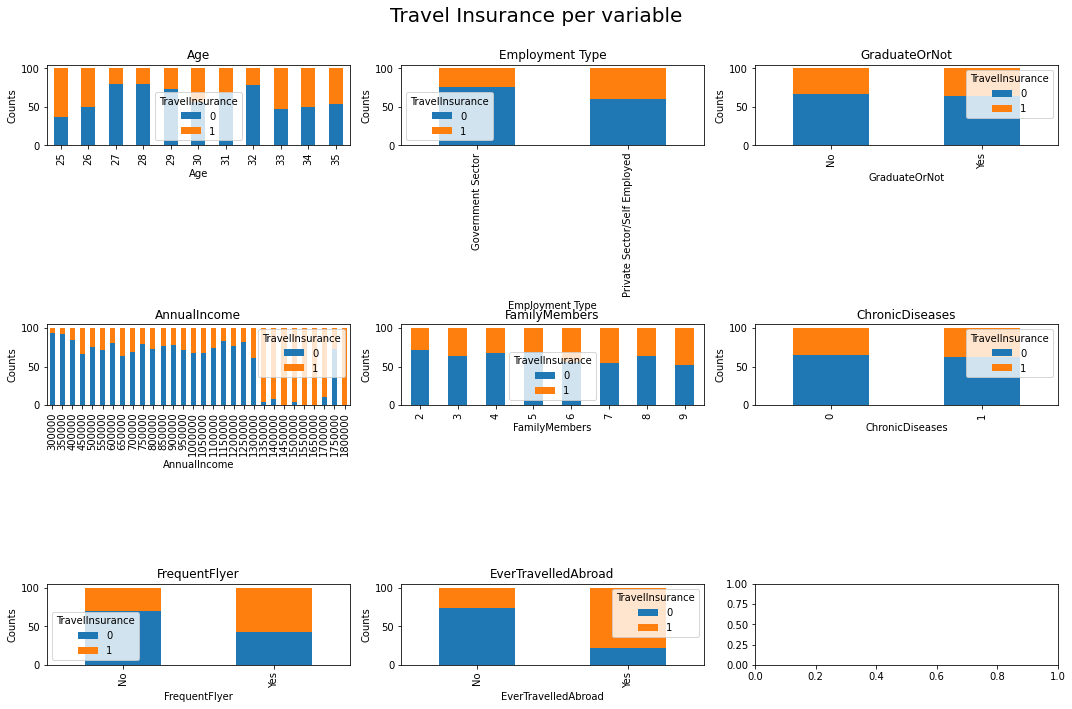

In [ ]:
#plot all the subplots
Subplots(df, "Travel Insurance per variable")

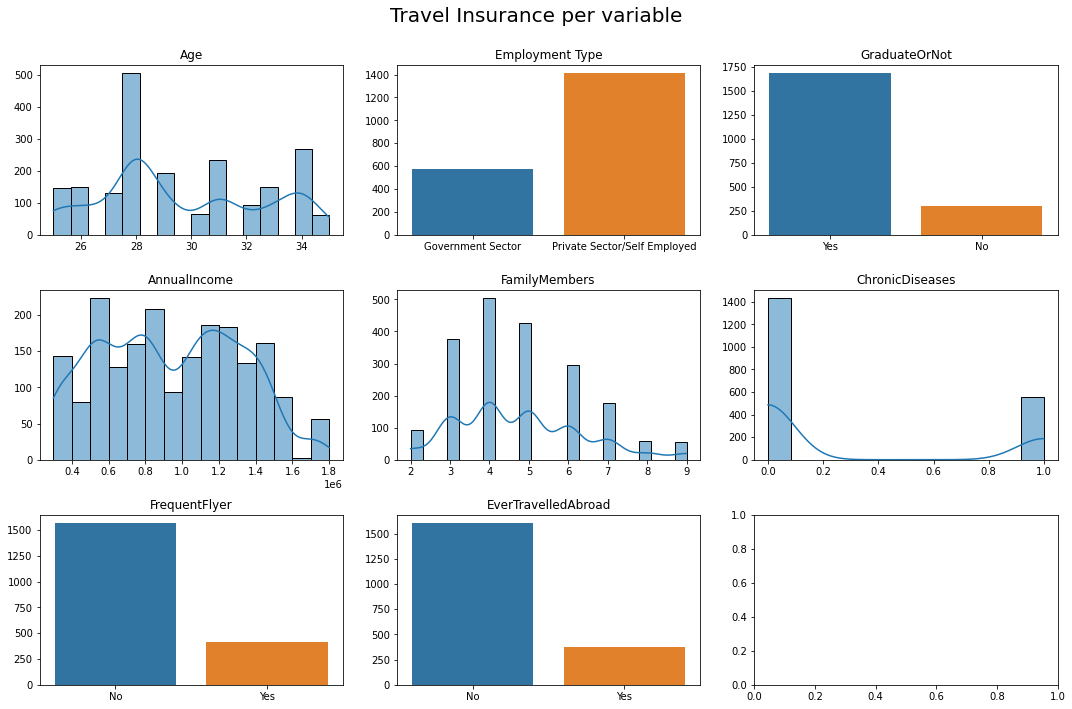

In [ ]:
plot_pdf(df,  "Travel Insurance per variable")

## **Feature Engineering**



In [ ]:
#separate categorical and numeric features
df["ChronicDiseases"]= df["ChronicDiseases"].map({0: "No", 1: "Yes"})
df["TravelInsurance"]= df["TravelInsurance"].map({0: "not purchased", 1: "purchased"})

cats = []
nums = []
for i in df.columns:
  if df[i].dtype=='object':
    cats.append(i)
  else:
    nums.append(i)
print('cats = ',cats)
print('nums = ',nums)

cats =  ['Employment Type', 'GraduateOrNot', 'ChronicDiseases', 'FrequentFlyer', 'EverTravelledAbroad', 'TravelInsurance']
nums =  ['Unnamed: 0', 'Age', 'AnnualIncome', 'FamilyMembers']


In [ ]:
# Categorizing AnnualIncome
bins = [0, 600000, 1250000, 1800000] # 0-600.000 -> low / 600.001 - 1.250.000 -> med / 1.250.001 - 1.800.000 -> high
groupNames = ["low", "med", "high"]
df['CatAnIncome'] = pd.cut(df['AnnualIncome'], bins, labels = groupNames, include_lowest = True)


## Total Original Data



In [ ]:
le = LabelEncoder()
to_encode = ['Employment Type','GraduateOrNot','ChronicDiseases','FrequentFlyer',
             'EverTravelledAbroad','TravelInsurance','CatAnIncome']
for index in to_encode:
    df[index] = le.fit_transform(df[index])

## Splitting Data



In [ ]:
df_random=df.sample(frac=1)
def split_dataset(df, test_frac):  
    X=df.drop(columns=["TravelInsurance","Unnamed: 0"], axis=1).values
    y=df["TravelInsurance"].values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_frac, random_state=seed_random)
    return X_train, X_test, y_train, y_test

# split test dataset for later testing
rows_train_valid = len(df)-int(test_frac* len(df))
train_valid_dataset = df_random.iloc[:rows_train_valid]
test_dataset=df_random.iloc[rows_train_valid:]

X_train, X_valid, y_train,   y_valid= split_dataset(train_valid_dataset, test_frac)
X_train2, y_train2= X_train, y_train

Xt=test_dataset.drop(columns=["TravelInsurance","Unnamed: 0"], axis=1).values
yt=test_dataset["TravelInsurance"].values

## Train Dataset distributions for Travel Insurance



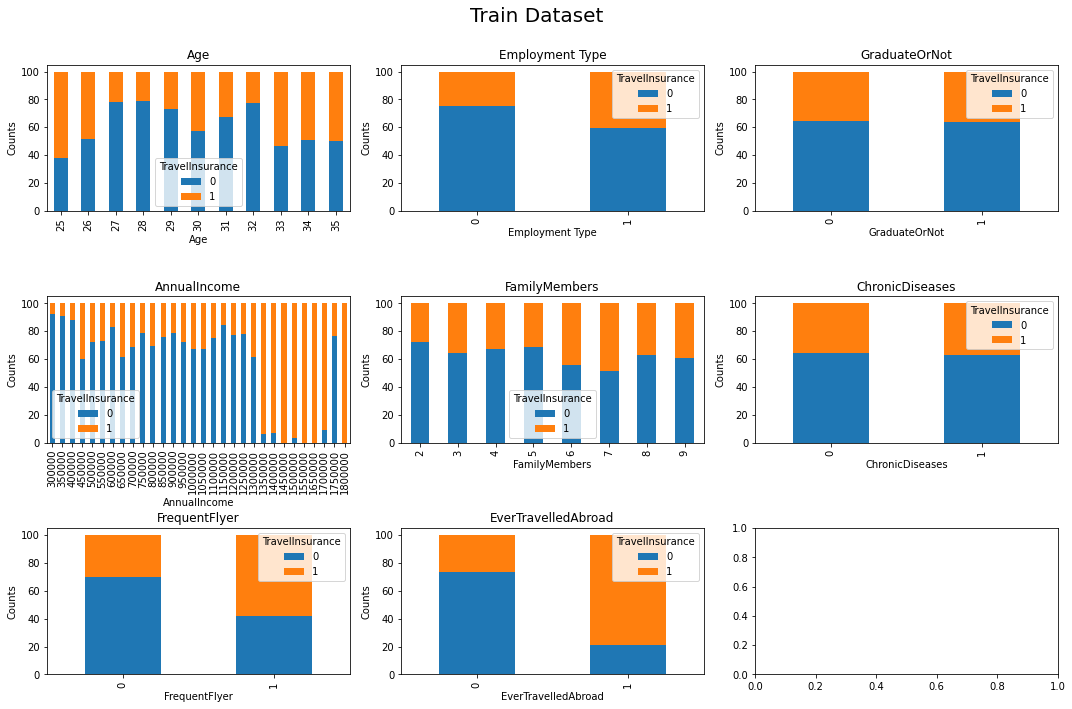

In [ ]:
Subplots(train_valid_dataset, "Train Dataset")

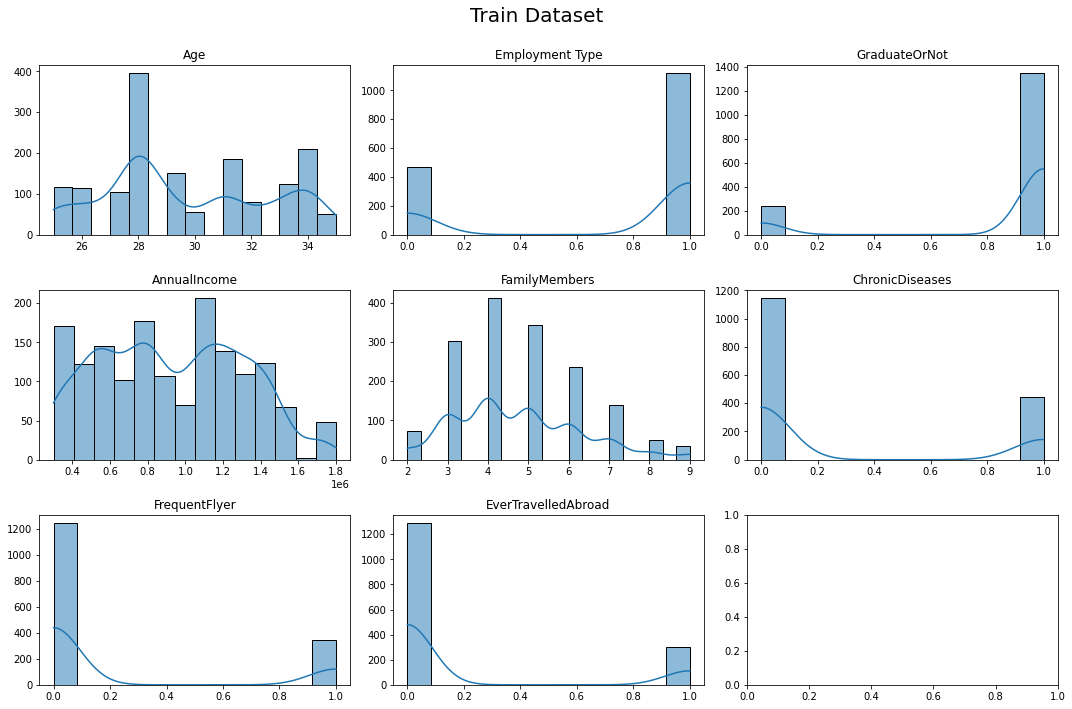

In [ ]:
plot_pdf(train_valid_dataset, "Train Dataset")

## Test Dataset distributions for Travel Insurance



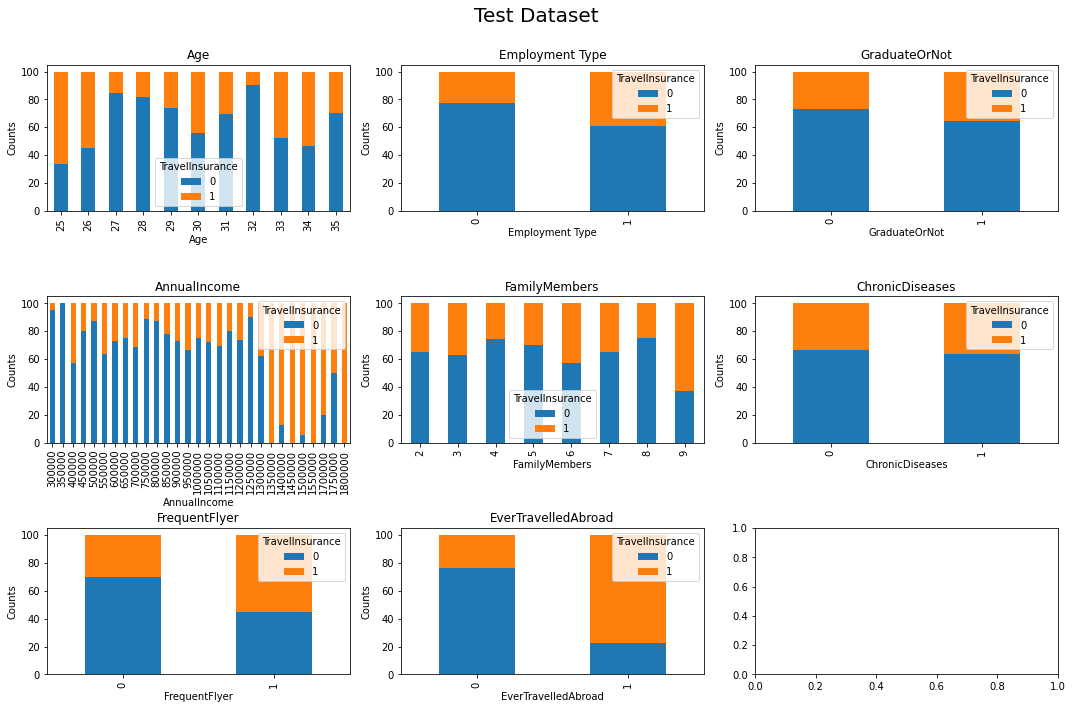

In [ ]:
Subplots(test_dataset, "Test Dataset")

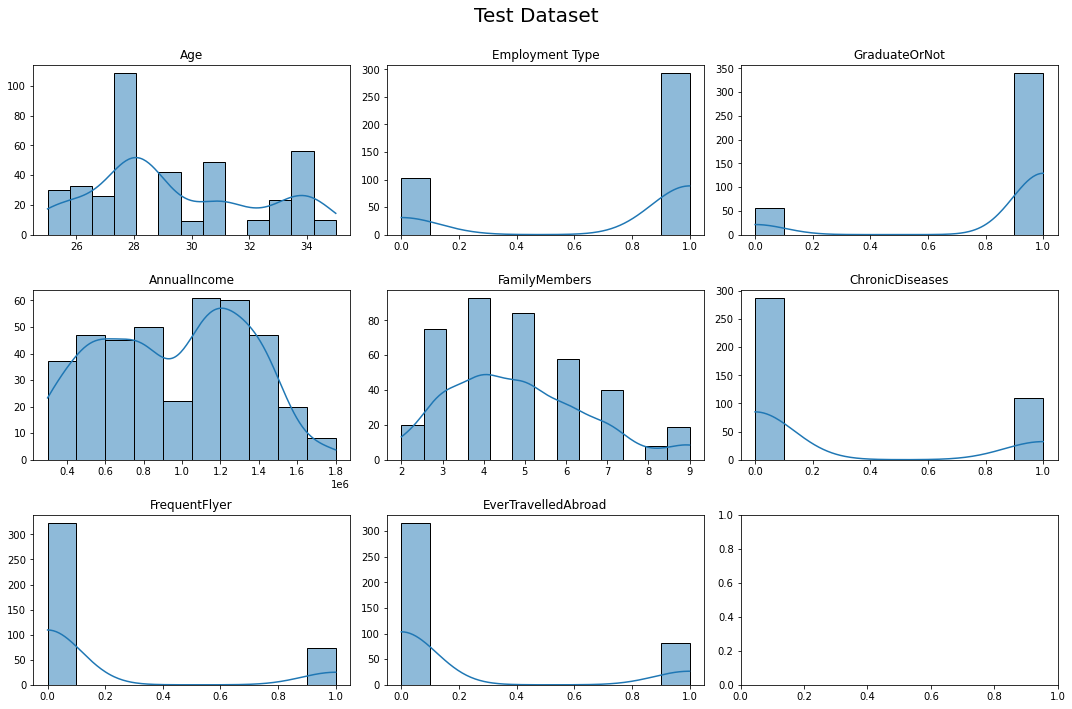

In [ ]:
plot_pdf(test_dataset, "Test Dataset")

### Test Data Set



In [ ]:
#Normalizing the data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
Xt=scaler.transform(Xt)

## Pytorch Training



In [ ]:
#Converting to Pytorch Sensors

X_valid=torch.tensor(X_valid, dtype=torch.float32)
y_valid=torch.tensor(y_valid, dtype=torch.float32)
Xt=torch.tensor(Xt, dtype=torch.float32)
yt=torch.tensor(yt, dtype=torch.float32)


In [ ]:
class TravelInsuranceNet(nn.Module):
    def __init__(self):
        super(TravelInsuranceNet, self).__init__()
        self.fc1=nn.Linear(X_train.shape[1],64)
        self.fc2=nn.Linear(64,32)
        self.fc3=nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x =torch.relu(self.fc1(x))
        x =torch.relu(self.fc2(x))
        x=self.sigmoid(self.fc3(x))
        return x

In [ ]:
def model_training(learning_rate, X_input, y_input, epochs, step_epoch):
    model=TravelInsuranceNet()
    # Loss and Optimizer
    criterion = nn.BCELoss()
    optimizer=optim.Adam(model.parameters(), lr=learning_rate)
    X_train=torch.tensor(X_input, dtype=torch.float32)
    y_train=torch.tensor(y_input, dtype=torch.float32)

    with tqdm(total=epochs, desc="Training model") as pbar:
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs=model(X_train)
            loss=criterion(outputs.squeeze(), y_train)
            loss.backward()
            optimizer.step()

            pbar.set_description(f"Training model, Loss {loss.item():.4f}")
            pbar.update(1)
            #if epoch % step_epoch ==0:
            #    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model

def model_evaluation(model, X_input, y_input):
    X_test=torch.tensor(X_input, dtype=torch.float32)
    y_test=torch.tensor(y_input, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred=y_pred.round()
        accuracy=(y_pred.squeeze()==y_test ).float().mean()
        predictions_np=y_pred.detach().cpu().numpy()

        prediction_scores=predictions_np

        true_labels_np = y_test.detach().cpu().numpy()
        predictions_np = (predictions_np > .5).astype(int)

        #Compute precision, Recall F1 Score
        precision=precision_score(true_labels_np, predictions_np)
        recall = recall_score(true_labels_np, predictions_np)
        f1 = f1_score(true_labels_np, predictions_np)
        conf_matrix=confusion_matrix(true_labels_np, predictions_np)

    return {
                "accuracy": accuracy, 
                "precision": precision,
                "recall": recall,
                "f1":f1,
                "conf_matrix":conf_matrix,
                "prediction_scores":prediction_scores
           }

    return accuracy

def display_evaluation(evaluation, label):
    print("\n",label)
    print(f'> Accuracy : {evaluation["accuracy"]:.4f}')
    print(f'> Precision : {evaluation["precision"]:.4f}')
    print(f'> Recall : {evaluation["recall"]:.4f}')
    print(f'> F1 Score : {evaluation["f1"]:.4f}')
    print(f"""> Confusion Matrix : 
                                Positive     |     Negative
                     Positive   {evaluation["conf_matrix"][0,0]}           | {evaluation["conf_matrix"][0,1]}
                     --------------------------------------
                     Negative   {evaluation["conf_matrix"][1,0]}           | {evaluation["conf_matrix"][1,1]}
                """)

In [ ]:
model1=model_training(learning_rate, X_train, y_train, epochs, step_epoch)
evaluation=model_evaluation(model1, X_valid, y_valid)
display_evaluation(evaluation, "Metrics for Validation Dataset")

evaluation_test=model_evaluation(model1, Xt, yt)
display_evaluation(evaluation_test, "Metrics for Test Dataset")

Training model, Loss 0.5830: 100%|██████████| 200/200 [09:40<00:00,  2.90s/it]
/tmp/ipykernel_12/174115435.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test=torch.tensor(X_input, dtype=torch.float32)
/tmp/ipykernel_12/174115435.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test=torch.tensor(y_input, dtype=torch.float32)
/tmp/ipykernel_12/174115435.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test=torch.tensor(X_input, dtype=torch.float32)
/tmp/ipykernel_12/174115435.py:30: UserWarning: To copy construct from a

## Use Synthetic data



In [ ]:
# merges real and synthetic data
dfsynth=pd.read_csv("Train_valid_20k.csv").sample(frac=.3)
dfsynth = pd.concat([dfsynth, train_valid_dataset], axis=0, ignore_index=True)

Xsynth=dfsynth.drop(columns=["TravelInsurance","Unnamed: 0"], axis=1).values
ysynth=dfsynth["TravelInsurance"].values


#Fit a new scaler
scaler2=StandardScaler()
Xsynth=scaler2.fit_transform(Xsynth)

Xt2=test_dataset.drop(columns=["TravelInsurance","Unnamed: 0"], axis=1).values
yt2=test_dataset["TravelInsurance"].values
Xt2=scaler2.transform(Xt2)

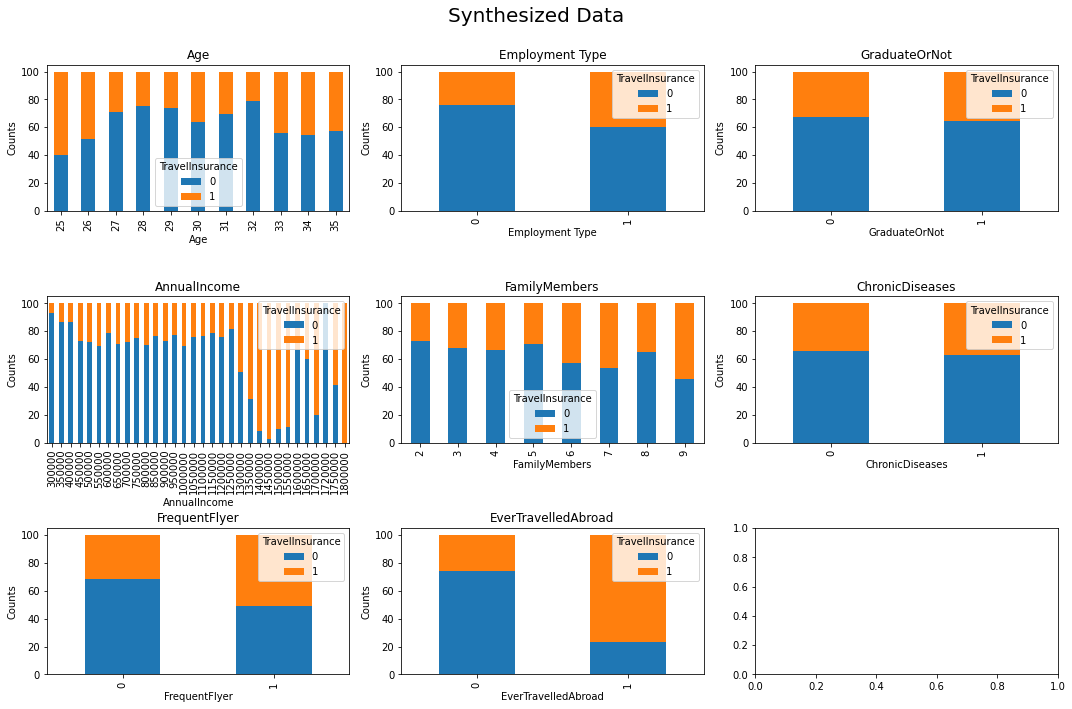

In [ ]:
Subplots(dfsynth, "Synthesized Data")

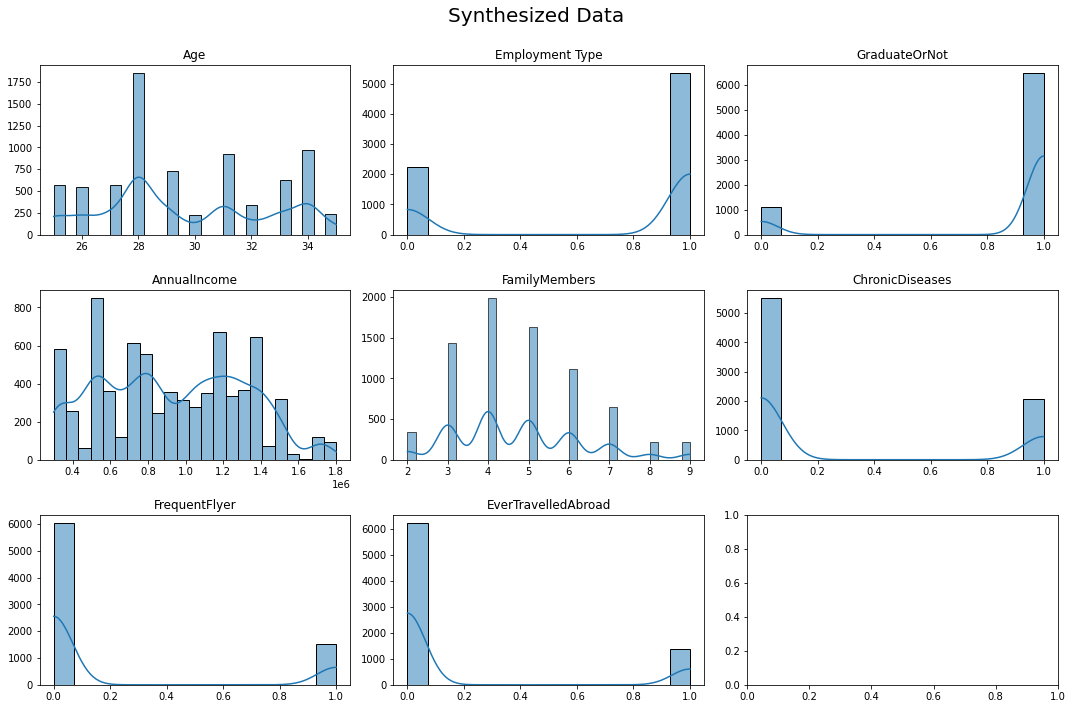

In [ ]:
plot_pdf(dfsynth, "Synthesized Data")

### Balance Data



In [ ]:
dfsynth_bougth=dfsynth[dfsynth.TravelInsurance==1]
dfsynth_notbougth=dfsynth[dfsynth.TravelInsurance==0].sample(n=len(dfsynth_bougth))
dfsynth=pd.concat([dfsynth_notbougth, dfsynth_bougth], axis=0, ignore_index=True).sample(frac=1)


## Training and evaluate with synthetic data



In [ ]:
model2=model_training(learning_rate, Xsynth, ysynth, epochs, step_epoch)
evaluation_synth=model_evaluation(model1, Xt2, yt2)



display_evaluation(evaluation_synth, "Metrics for Test Dataset using the synth trained model")



Training model, Loss 0.5847: 100%|██████████| 200/200 [08:34<00:00,  2.57s/it]

 Metrics for Test Dataset using the synth trained model
> Accuracy : 0.8161
> Precision : 0.8902
> Recall : 0.5328
> F1 Score : 0.6667
> Confusion Matrix : 
                                Positive     |     Negative
                     Positive   251           | 9
                     --------------------------------------
                     Negative   64           | 73
                


Synthetic Data Exploration



Check for each group



In [ ]:
dataX=[

        [           "real data", 
                    round(evaluation["accuracy"].item(),2),
                    round(evaluation["recall"],2),
                    round(evaluation["precision"],2),
                    round(evaluation["f1"],2)

        ],
        [           "synth data",
                    round(evaluation_synth["accuracy"].item(),2),
                    round(evaluation_synth["recall"],2),
                    round(evaluation_synth["precision"],2),
                    round(evaluation_synth["f1"],2)
        ]
]

dfResults= pd.DataFrame(
        data = dataX,
        columns=["experiment", "accuracy", "recall", "precision", "f1"]
)


In [ ]:
dfResults

/tmp/ipykernel_12/1998566729.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(dfResults['experiment'], rotation=45)
/tmp/ipykernel_12/1998566729.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(dfResults['experiment'], rotation=45)
/tmp/ipykernel_12/1998566729.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(dfResults['experiment'], rotation=45)
/tmp/ipykernel_12/1998566729.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(dfResults['experiment'], rotation=45)


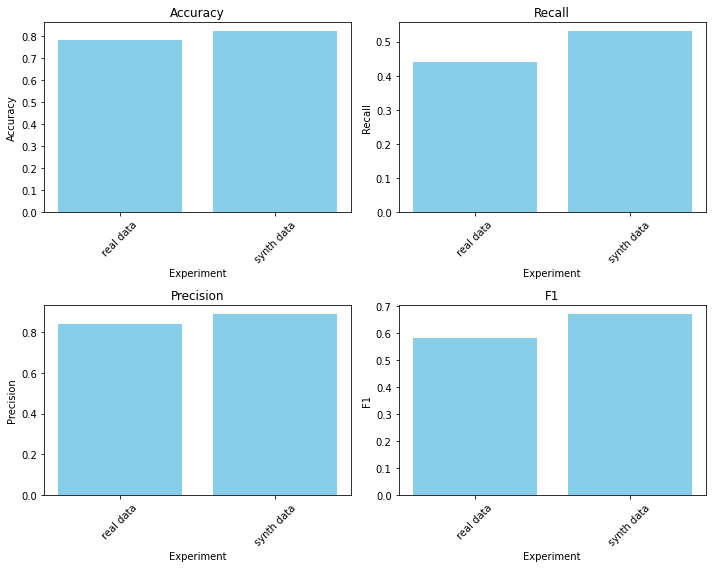

In [ ]:
metrics = ['accuracy', 'recall', 'precision', 'f1']

# Number of rows and columns in the subplot grid
n_rows = 2
n_cols = 2

# Create a figure and a set of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    axs[i].bar(dfResults['experiment'], dfResults[metric], color='skyblue')
    
    # Setting titles and labels
    axs[i].set_title(metric.capitalize())
    axs[i].set_xlabel('Experiment')
    axs[i].set_ylabel(metric.capitalize())
    axs[i].set_xticklabels(dfResults['experiment'], rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

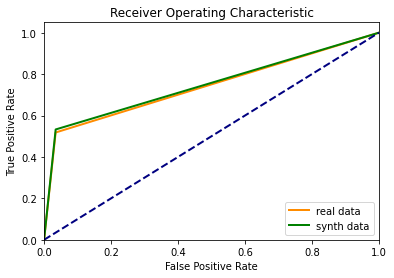

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(yt2, evaluation_test["prediction_scores"])
fpr2, tpr2, thresholds2 = roc_curve(yt2, evaluation_synth["prediction_scores"])

# Plot the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='real data')
plt.plot(fpr2, tpr2, color='green', lw=2, label='synth data')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()